## Importing necessary libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from nltk.stem import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Data is stored in Google drive but original source is as under:
### source: https://www.kaggle.com/datasets/yasserh/imdb-movie-ratings-sentiment-analysis

In [3]:
df=pd.read_csv('/content/drive/MyDrive/data/movie.csv')

In [4]:
df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


## Lets see whether the dataset is balanced or not

In [5]:
df['label'].value_counts()

0    20019
1    19981
Name: label, dtype: int64

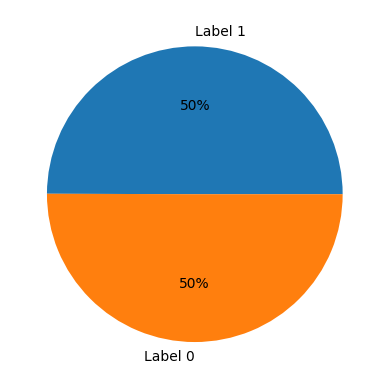

In [6]:
count_pos=df['label'].value_counts()[1]
count_neg=df['label'].value_counts()[0]
plt.pie([count_pos,count_neg],labels=['Label 1','Label 0'],autopct='%.0f%%')
plt.show()

## Define the preprocess function

In [7]:
def process_text(review):
    clean_rev=list()
    stemmer=PorterStemmer()
    tokenizer=TreebankWordTokenizer()
    stopwords_english=stopwords.words('english')
    punctuation=string.punctuation
    token_words=tokenizer.tokenize(review)
    for word in token_words:
        if (word not in stopwords_english and word not in punctuation):
            stem_word=stemmer.stem(word)
            clean_rev.append(stem_word)
    return clean_rev

## Defining the frequency calculator function

In [8]:
def freq_builder(reviews, y):
    y = np.squeeze(y).tolist()
    freq = {}
    for label, review in zip(y, reviews):
        for word in process_text(review):
            pair = (word, label)
            if pair in freq:
                freq[pair] += 1
            else:
                freq[pair] = 1
    return freq

## Splitting the data

In [9]:
split_index = int(len(df) * 0.8)  # Calculate the index for the split
# Split the DataFrame into training and testing sets
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

In [10]:
train_df.shape,test_df.shape

((32000, 2), (8000, 2))

In [11]:
'''
Lets split it into the x, and y
'''
x_train=train_df.drop(['label'],axis=1)
y_train=train_df['label']
x_test=test_df.drop(['label'],axis=1)
y_test=test_df['label']

## Lets get the frequencies of word

In [12]:
x_train.shape,y_train.shape

((32000, 1), (32000,))

## Converting x_train,x_test,y_train,y_test into numpy array , we could have done in the above step or we could just use train_test_split() method but I thought to make it simple

In [13]:
x_train=np.array(x_train['text'])
y_train=np.array(y_train)
x_test=np.array(x_test['text'])
y_test=np.array(y_test)

In [16]:
freqs=freq_builder(x_train,y_train)

In [17]:
len(freqs)

160950

## Now lets implement the Naive Bayes Algorithm

In [63]:
def check_freq(freq,word,y):
  '''
  This function return the frequency of the pair in the freq dictionary
  '''
  pair=(word,y)
  if pair in freq:
    return freq[pair]
  else:
    return 0

In [19]:
def naive_bayes(freq,x_train,y_train):
  lambda_log ={} # Also known as log liklihood
  log_prior=0 # log(P(Dpos)/P(Dneg))
  vocabulary=set([pair[0] for pair in freq])
  len_vocab=len(vocabulary)
  no_pos=0
  no_neg=0
  for pair in freq.keys():
    if pair[1]>0:
      no_pos+=freq[pair]
    else:
      no_neg+=freq[pair]
  d=len(x_train)
  d_pos=len([filter(lambda x : x>0,y_train)])
  d_neg=len([filter(lambda x : x<=0,y_train)])
  log_prior=np.log(d_pos)-np.log(d_neg) # used log property log(dpos/dneg) == log(dpos)-log(dneg)
  for word in vocabulary:
    pos_freq=check_freq(freq,word,1)
    neg_freq=check_freq(freq,word,0)

    '''
    Calculating the probabilities with lapalace smoothing
    '''
    pos_prob=(pos_freq+1)/(no_pos+len_vocab)
    neg_prob=(neg_freq+1)/(no_neg+len_vocab)

    '''
    Now lets update the liklihood(lambda) for each word
    '''
    lambda_log[word]=np.log(pos_prob)-np.log(neg_prob)
  return log_prior,lambda_log

In [21]:
log_prior,lambda_log=naive_bayes(freqs,x_train,y_train)

In [ ]:
# log_prior,lambda_log # Its a long dict , you can print and see

In [31]:
def predict(text,lamda_log=lambda_log,log_prior=log_prior):
  clean_text=process_text(text)
  prob=0
  prob+=log_prior # if we dont have any information about the logliklihood then its probability is log_prior
  for word in clean_text:
    if word in lambda_log: # means if word exist in liklihood keys
      prob+=lambda_log[word]
  if prob>0:
    return True
  else:
    return False

## Now Its the time to predict our own texts

In [56]:
def accuracy(x_test,y_test,log_prior=log_prior,lambda_log=lambda_log):
  accuracy=0 # in start the accuracy is 0
  ypred=[]
  for word in x_test:
    if predict(word,lambda_log,log_prior):
      ypred.append(1)
    else:
      ypred.append(0)
  accuracy=1-np.mean(np.absolute(ypred-y_test))
  return accuracy

In [57]:
print(accuracy(x_test,y_test,log_prior=log_prior,lambda_log=lambda_log))

0.8538749999999999


In [62]:
text='xyz 2 is a terrible movie , i hope they will make good movies in the future'
if(predict(text)):
  print('Sentiment is Positive')
else:
  print('Sentiment is Negative')

Sentiment is Negative
